# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [37]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [38]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [39]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9973 / 11441 MB available


In [40]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    /*
        c[j][i] = a[j][i] + b[j][i];
    */
    unsigned int k = j*cols+i;
    c[k] = a[k]+b[k];
}

// Need to implement ...
__global__ void matrixVectorKernel(float*c, float* A, float* b, int a_rows, int a_cols) {
    // for loop that computes the vector-vector inner prod of row j of A by our vector b, and store the result in c[j]
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    float temp = 0.0f;
    for(int i = 0; i<a_cols; i++) {
        int k = j*a_cols+i;
        temp += A[k]*b[i];
    }
    c[j] = temp;
}
"""

In [41]:
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [42]:
#Size of our test
test_size = (4,3)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.rand(test_size[1]).astype(np.float32)
c = np.zeros((test_size[0],1)).astype(np.float32)

print(a)
print(b)
print(c)

# fig = plt.figure(figsize=(12,8))
# plt.imshow(a)
# plt.colorbar()
# fig.show()

[[0.474854   0.28646687 0.06153389]
 [0.34838405 0.5646444  0.94138217]
 [0.62584585 0.9321647  0.5258898 ]
 [0.9646251  0.31930682 0.42395905]]
[0.03538679 0.04140472 0.80065966]
[[0.]
 [0.]
 [0.]
 [0.]]


In [43]:
print(a.shape)

(4, 3)


In [44]:
#Upload data to the device
# NOTE: need to make sure that a=(rows, colums)
# and that b=(colums in a, 1)
# c = (a_rows, 1)
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [45]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [46]:
domain_size = (1,a.shape[0])
# NOTE: we need to change block*grid to be x = 1, y = num_of_rows_a
# block_size = (1, 1, 1)
# grid_size = (domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)
block_size = (1, 1, 1)
grid_size = (domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)
print(domain_size)
print(block_size)
print(grid_size)

(1, 4)
(1, 1, 1)
(1, 4, 1)


In [47]:
#Execute program on device
cols = a.shape[1]
rows = a.shape[0]
print(cols)
print(rows)

3
4


In [48]:
kernel(c_g, a_g, b_g, np.int32(rows), np.int32(cols), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.07793234],
       [0.78943384],
       [0.48180145],
       [0.3868027 ]], dtype=float32)

In [49]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(np.transpose(c) - c_ref)))

C   =  [[0.07793234]
 [0.78943384]
 [0.48180145]
 [0.3868027 ]]
Ref =  [0.07793234 0.78943384 0.48180145 0.3868027 ]
Sad =  0.0


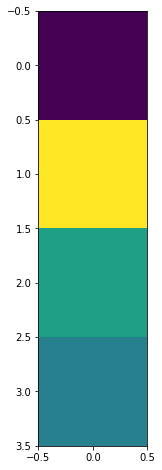

In [51]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)